In [388]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import caustics
from IPython.display import HTML
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
! python --version #VS code label wrong. Need <3.11 for mcmc in pylima

Python 3.10.14


In [390]:
cosmology = caustics.FlatLambdaCDM()
point_lens = caustics.Point(cosmology=cosmology, name="lens")
src = caustics.PointSource(name="source")

In [469]:
n_pix = 100
res = 0.05
upsample_factor = 10
theta_x, theta_y = caustics.utils.meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    dtype=torch.float32,
)

In [461]:
class Microlens(caustics.Simulator):
    def __init__(
        self, lens, src, theta_x=None, theta_y=None, z_s=None, name: str = "sim"
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src

        self.add_param("theta_x", theta_x)
        self.add_param("theta_y", theta_y)
        self.add_param("z_s", z_s)

    def forward(self, params):
        theta_x, theta_y, z_s = self.unpack(params)
        beta_x, beta_y = self.lens.raytrace(theta_x, theta_y, z_s, params)
        brightness = self.src.brightness(beta_x, beta_y, params)
        baseline_brightness = self.src.brightness(theta_x, theta_y, params)
        return brightness, brightness.mean() / baseline_brightness.mean()


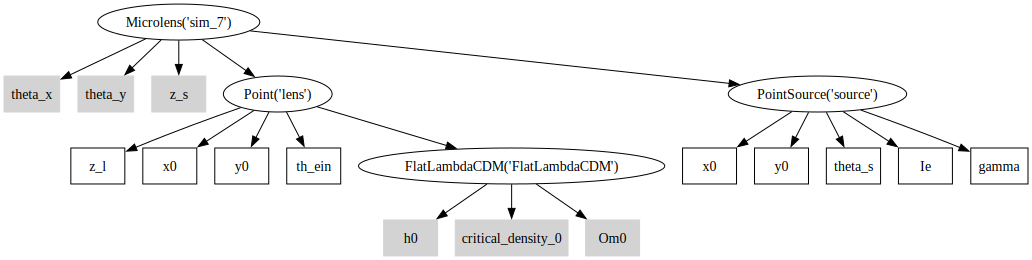

In [462]:
sim = Microlens(point_lens, src, theta_x=theta_x, theta_y=theta_y, z_s=0.0)
sim.graph(True, True)

In [463]:
sim.x_order

['lens.z_l',
 'lens.x0',
 'lens.y0',
 'lens.th_ein',
 'source.x0',
 'source.y0',
 'source.theta_s',
 'source.Ie',
 'source.gamma']

In [530]:
# Microlensing Physical Parameters
th_ein = 0.1  # Einstein radius in arcsec

# Microlensing Model Parameters
t0 = 0.2  # time at peak magnification
u0 = 0.5 * th_ein  # minimum impact parameter (u(t=t_0)) in units of th_ein
tE = 0.05 # Einstein timescale
rho = 3.0  # source size in units of lens Einstein radii

gamma = 0.0  # linear limb darkening coefficient

In [531]:
B = 64  # Batch size
ts = torch.linspace(-6 * tE + t0, 6 * tE + t0, B).view(-1, 1)  # Create time grid

# Calculate source position at each time in arcsec
x0s = (ts - t0) / (tE) * th_ein  # Shape is [B, 1]

# Since source is assumed radially symmetric, can set all motion in the x direction
y0s = -u0 * torch.ones_like(x0s)

In [532]:
x = torch.tensor(
    [
        0.0,  # z_l
        0.0,  # x0
        0.0,  # y0
        th_ein,  # th_ein
        0.0,  # x0
        0.0,  # y0
        th_ein * rho,  # theta_s
        5.0,  # Ie,
        gamma,  # gamma
    ]
)

newx = x.repeat(B, 1)
newx[:, 1] = x0s.view(-1)
newx[:, 2] = y0s.view(-1)

In [533]:
images, magnifications = torch.vmap(sim)(newx)

In [534]:
# Create animation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Display the first frame of the image in the first subplot
img = ax1.imshow(images[0].numpy(), cmap="cividis", interpolation="bilinear")
ax1.set_title("Image")

# Set up the scatter plot for magnifications in the second subplot
scatter = ax2.scatter(ts[0].item(), magnifications[0].item())
ax2.set_xlim(ts.min().item(), ts.max().item())
ax2.set_ylim(magnifications.min().item() * 0.9, magnifications.max().item() * 1.1)
ax2.axvline(-tE / 2, color="r", linestyle="--")
ax2.axvline(tE / 2, color="r", linestyle="--")
ax2.set_xlabel("t")
ax2.set_ylabel("A")


def update(frame):
    """Update function for the animation."""
    # Update the image in the first subplot
    img.set_array(images[frame].numpy())

    # Update the scatter plot in the second subplot
    ax2.clear()  # Clear the previous frame
    ax2.scatter(ts[: frame + 1].numpy(), magnifications[: frame + 1].numpy())
    ax2.set_xlim(ts.min().item(), ts.max().item())
    ax2.set_ylim(magnifications.min().item() * 0.9, magnifications.max().item() * 1.1)
    ax2.axvline(-tE / 2 + t0, color="r", linestyle="--")
    ax2.axvline(tE / 2 + t0, color="r", linestyle="--")
    ax2.set_xlabel("t")
    ax2.set_ylabel("A")
    ax2.set_title("Light-Curve")

    return img, scatter


ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

# Save animation as gif
# ani.save("microlensing_animation.gif", writer='pillow', fps=16)  # Adjust 'fps' for the speed

# Or display the animation inline
HTML(ani.to_jshtml())

In [535]:
# noise = 0.01 * torch.randn_like(magnifications)
noise = 0.00 * torch.randn_like(magnifications)
noisy_mags = magnifications + noise
err_mag = 0.02 * torch.ones_like(magnifications)  # set fixed error for now
data = np.vstack((ts.view(-1), noisy_mags, err_mag)).T

np.savez("assets/microlensing_dat", data=data)